In [1]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [2]:
# setting up the notebook width to 100% of the screen
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# 1. import libraries

In [39]:
import time
import json
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import sweetviz as sv
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from scipy.stats import uniform, randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold

## 2. load data

In [4]:
df = pd.read_csv("./fraud_oracle.csv")

In [5]:
df.shape

(15420, 33)

In [6]:
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [7]:
df.head().T

,0,1,2,3,4
Month,Dec,Jan,Oct,Jun,Jan
WeekOfMonth,5,3,5,2,5
DayOfWeek,Wednesday,Wednesday,Friday,Saturday,Monday
Make,Honda,Honda,Honda,Toyota,Honda
AccidentArea,Urban,Urban,Urban,Rural,Urban
DayOfWeekClaimed,Tuesday,Monday,Thursday,Friday,Tuesday
MonthClaimed,Jan,Jan,Nov,Jul,Feb
WeekOfMonthClaimed,1,4,2,1,2
Sex,Female,Male,Male,Male,Female
MaritalStatus,Single,Single,Married,Married,Single


                                             |          | [  0%]   00:00 -> (? left)


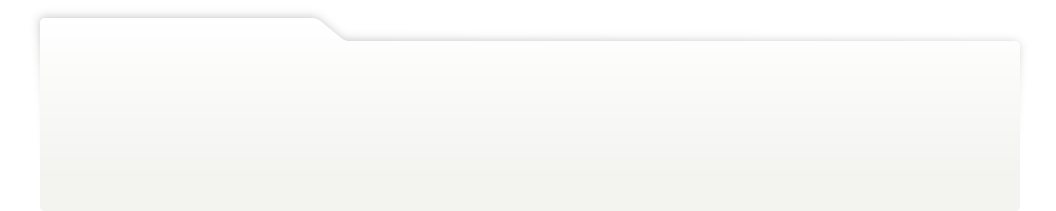
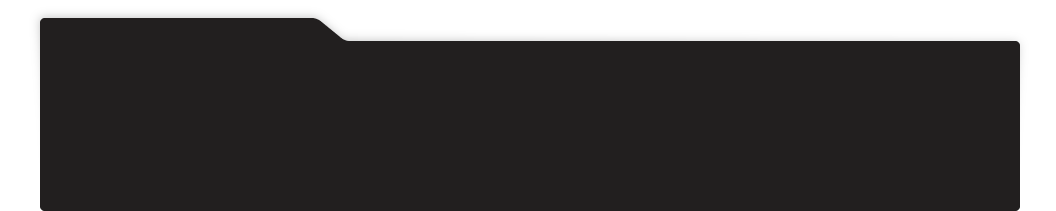
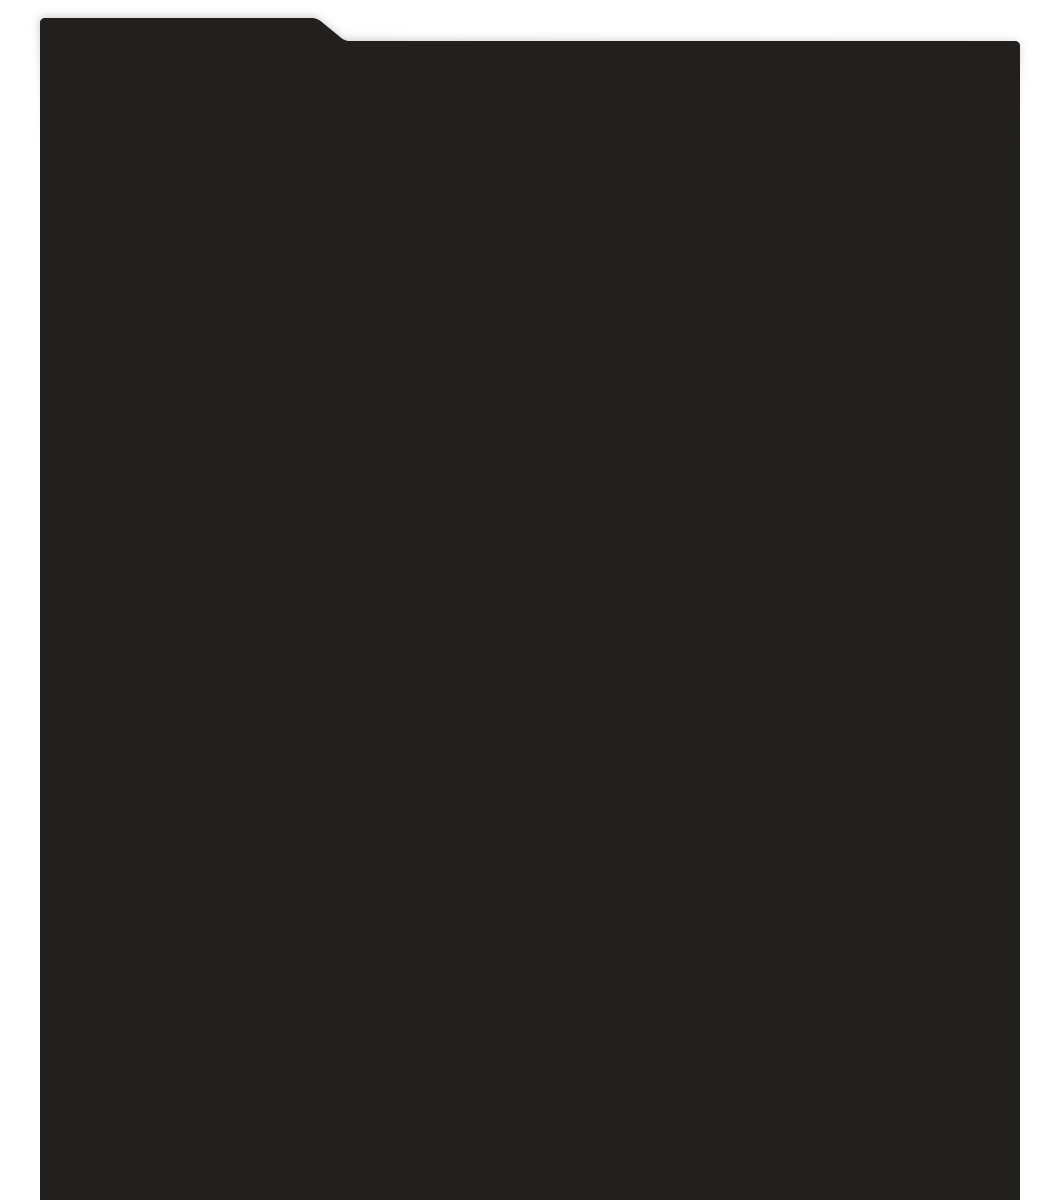
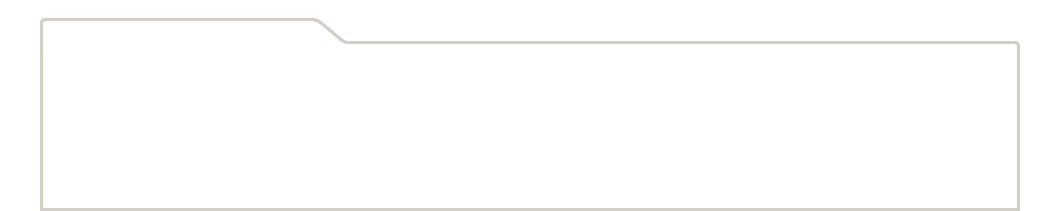
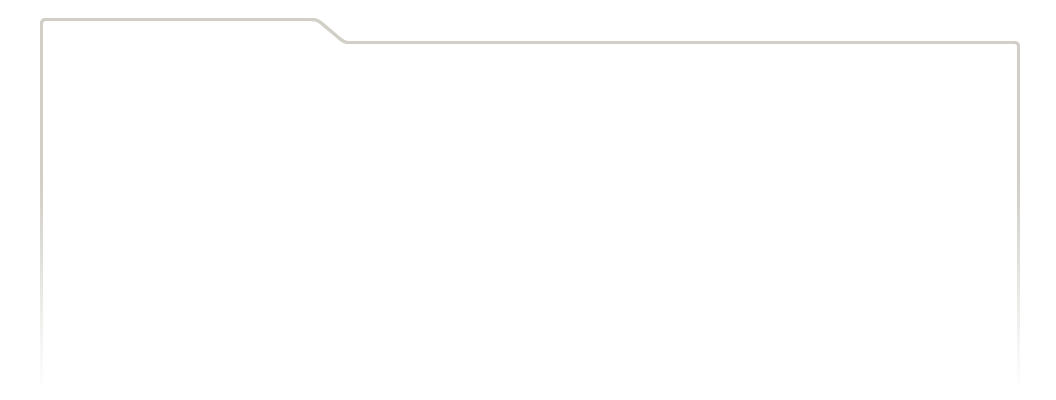
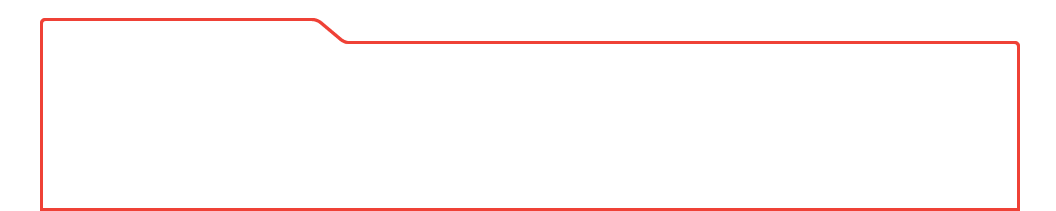
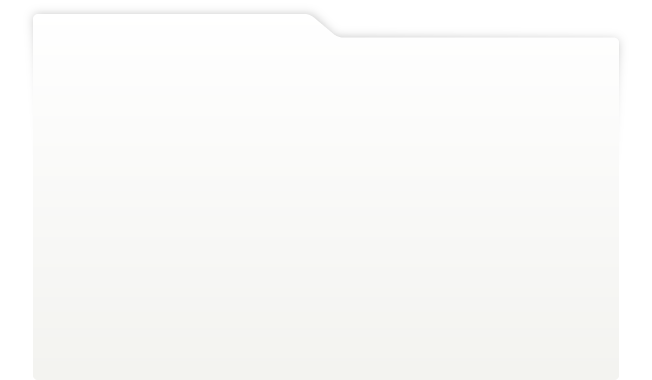
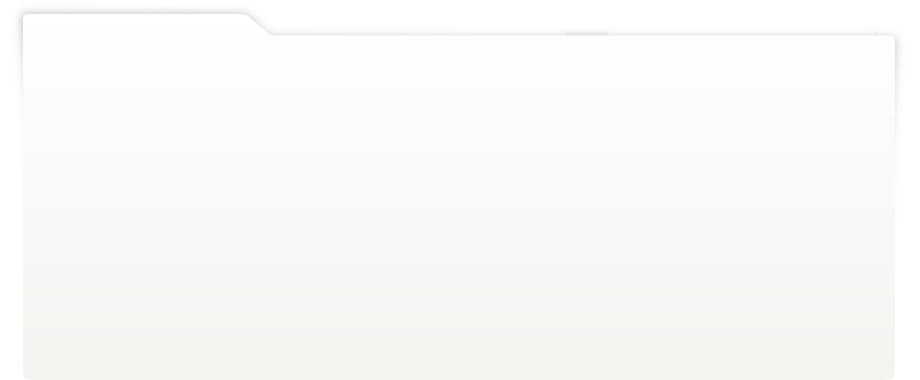
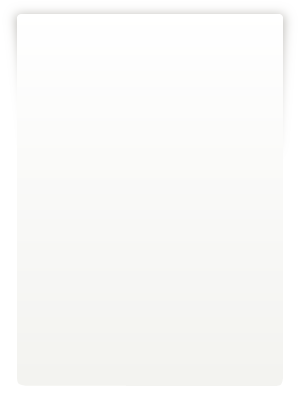
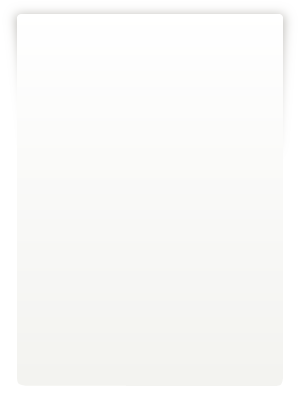
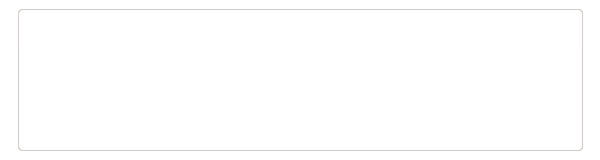
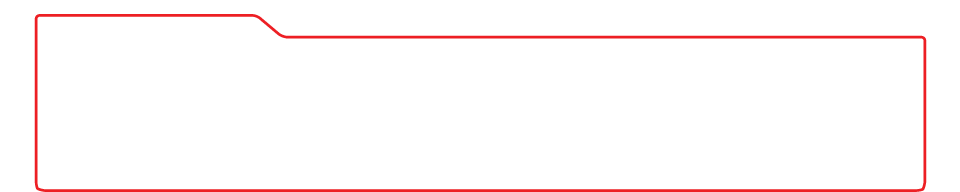
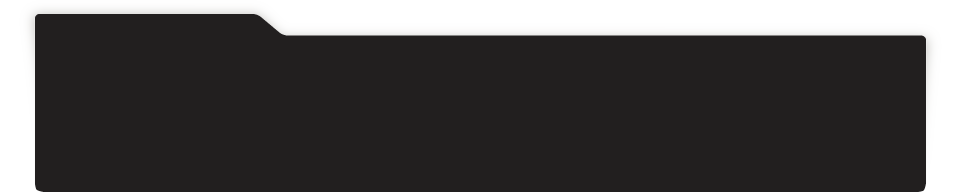
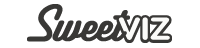
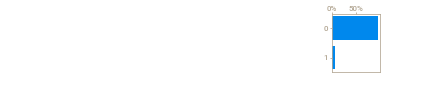
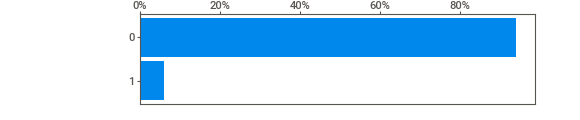
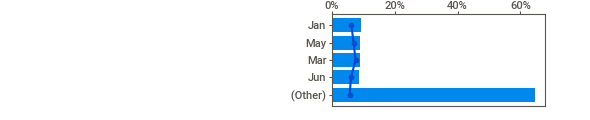
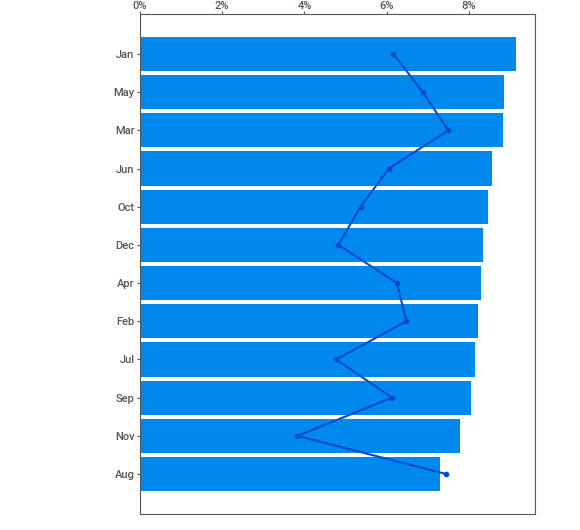
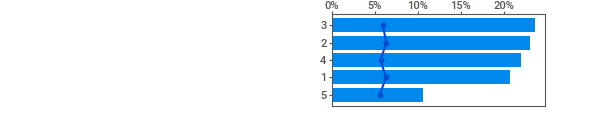
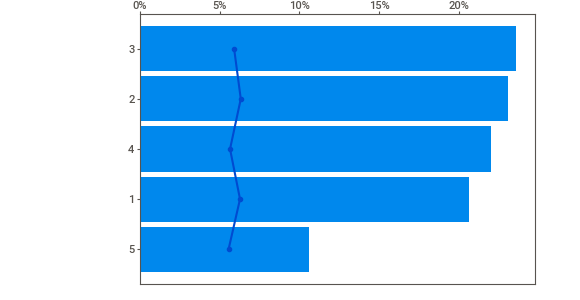
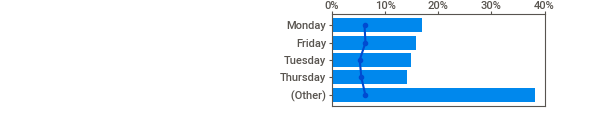
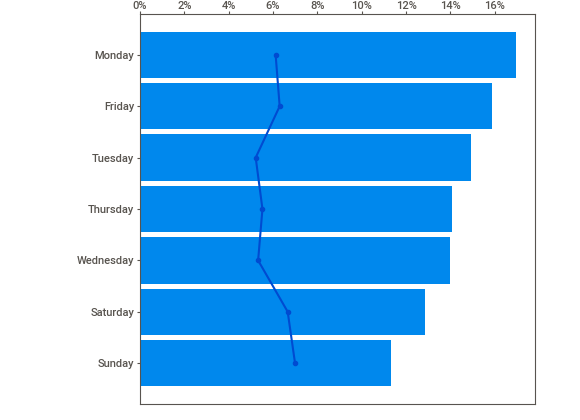
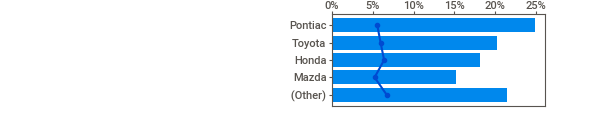
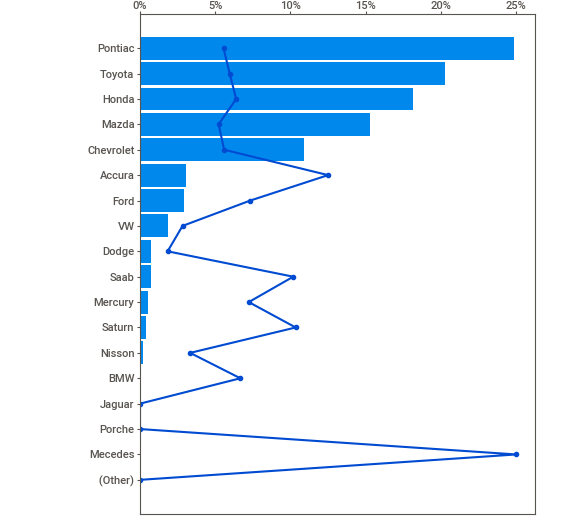
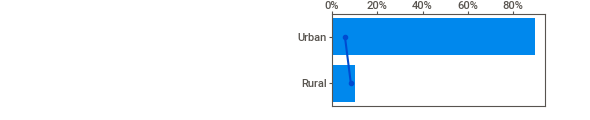
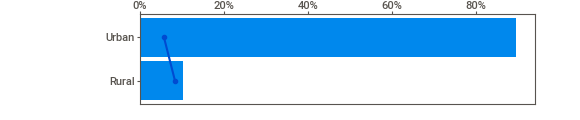
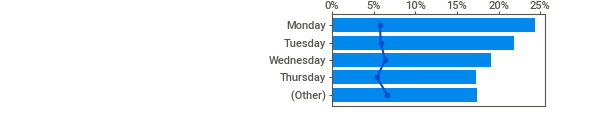
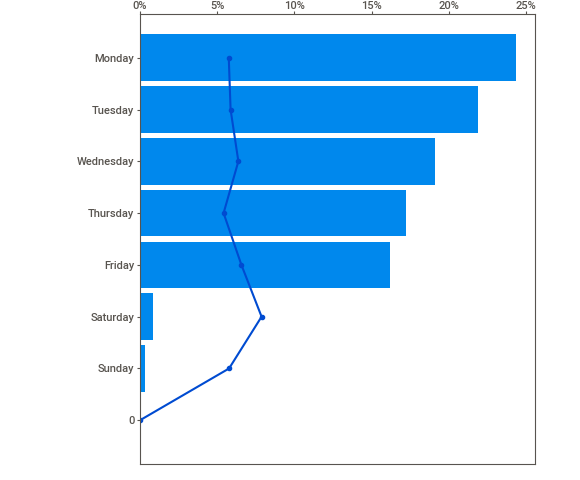
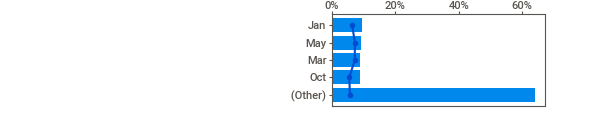
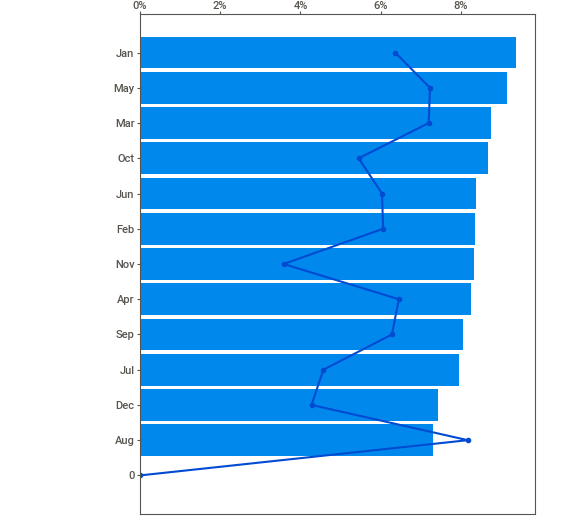
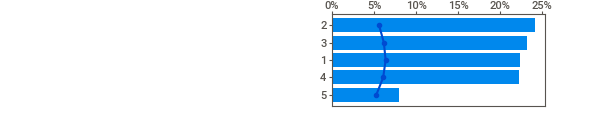
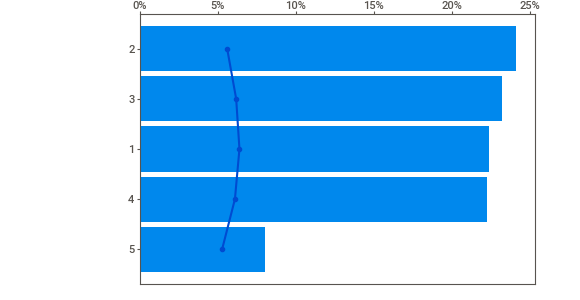
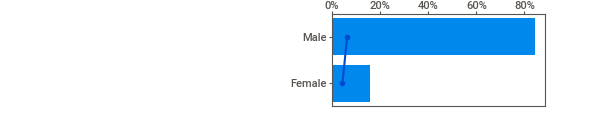
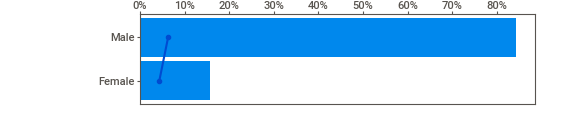
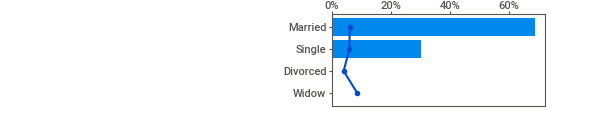
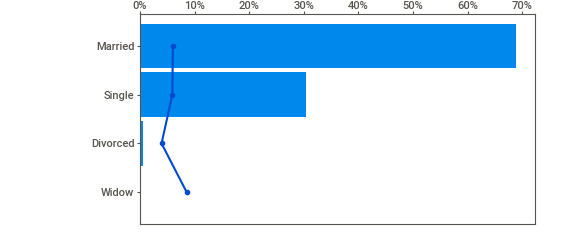
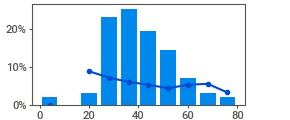
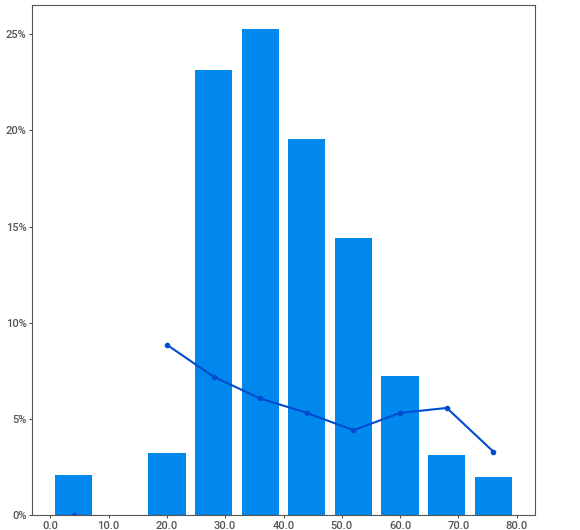
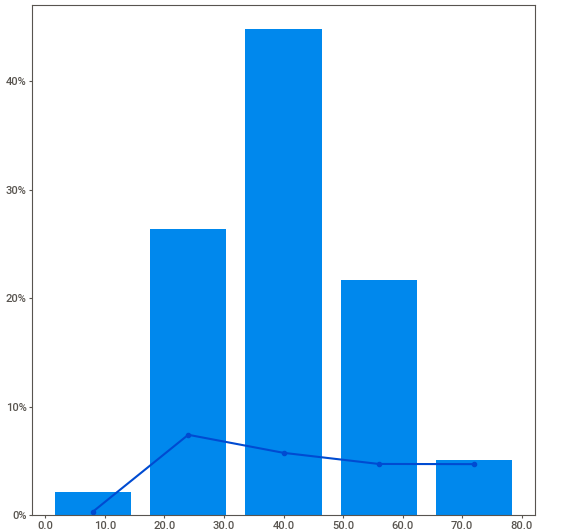
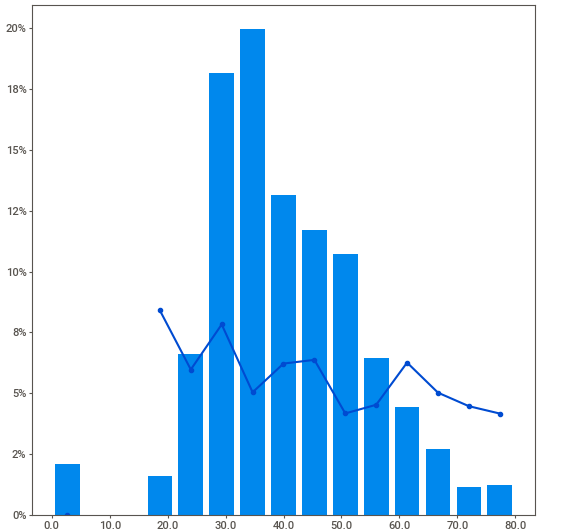
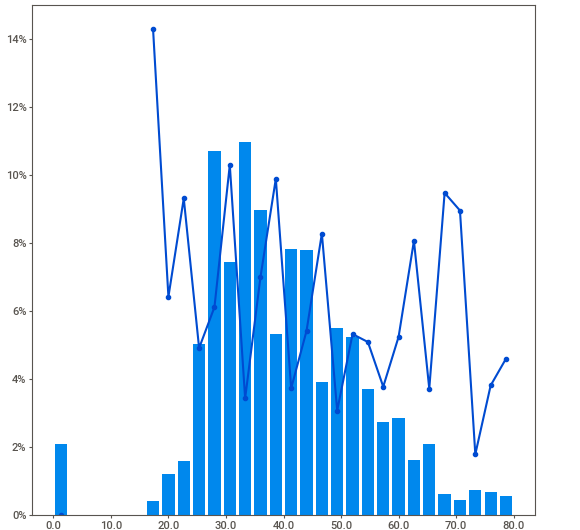
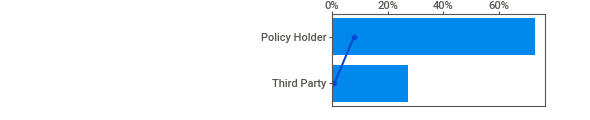
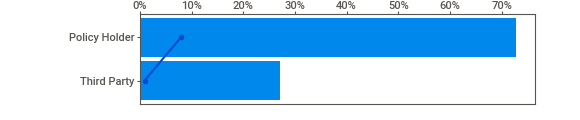
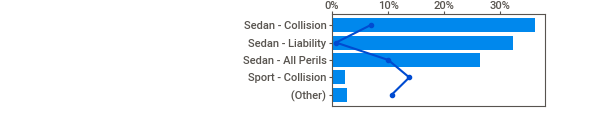
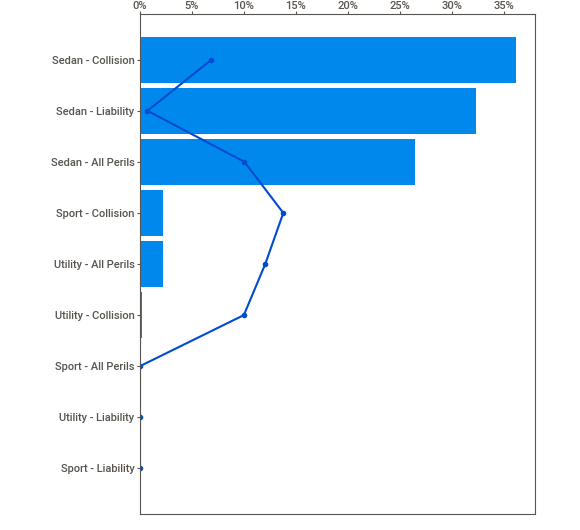
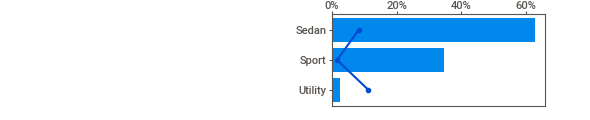
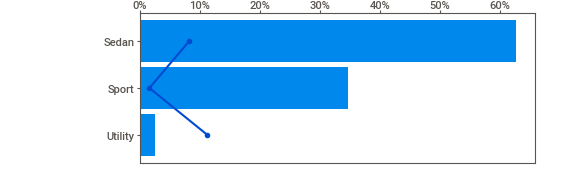
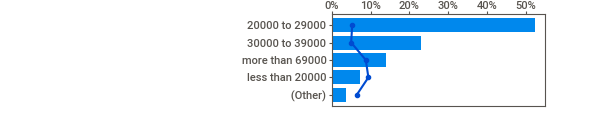
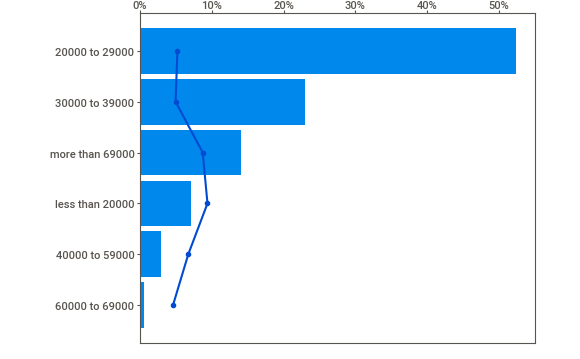
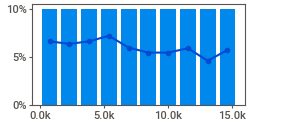
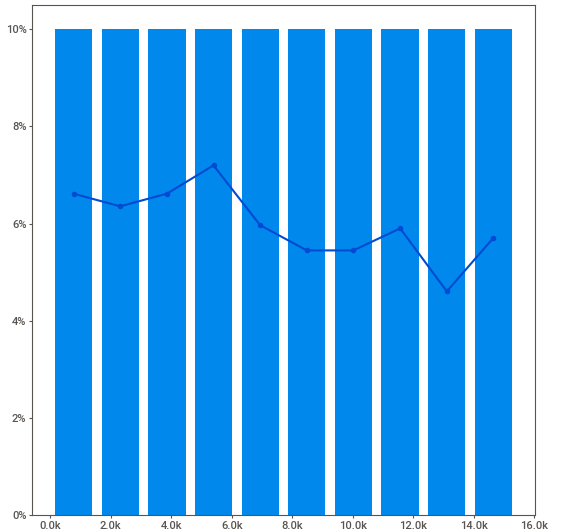
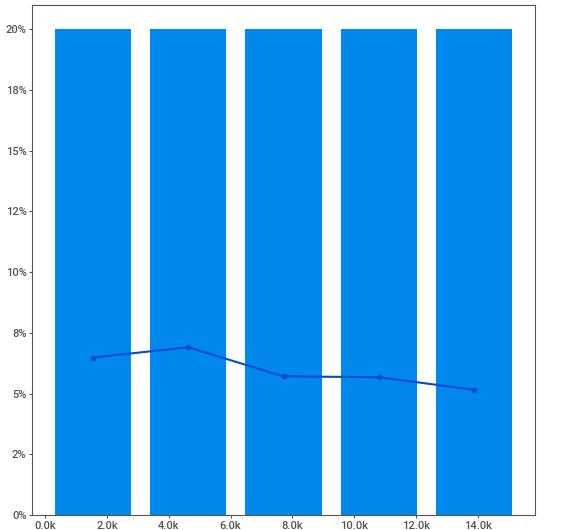
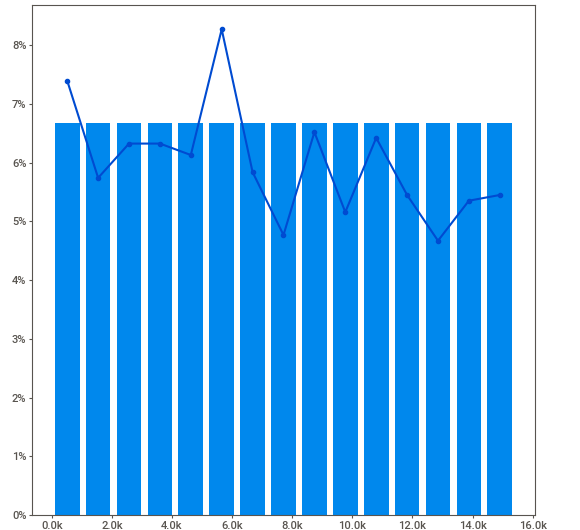
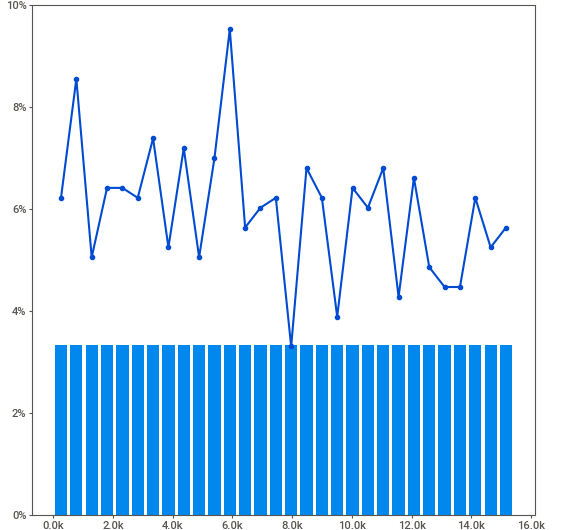
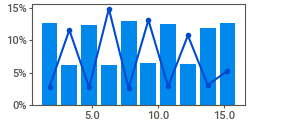
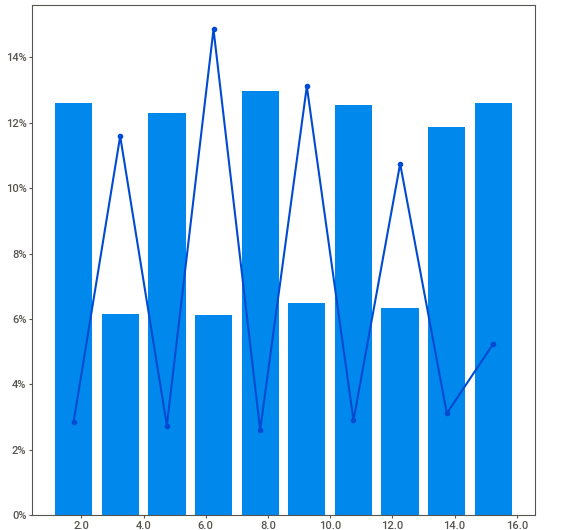
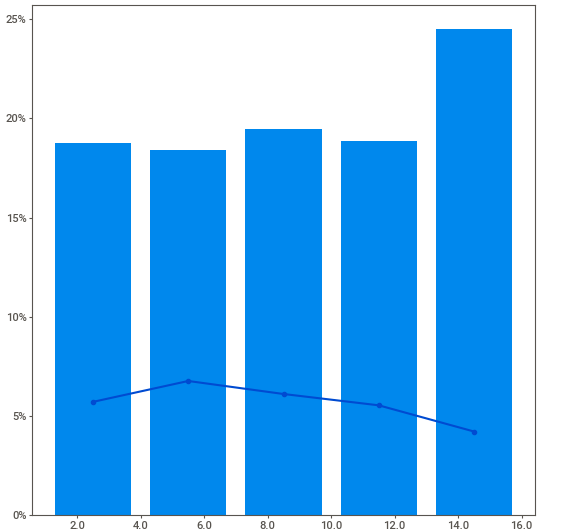
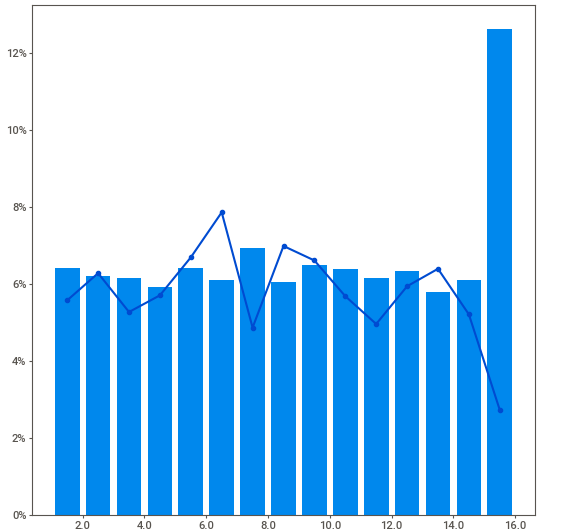
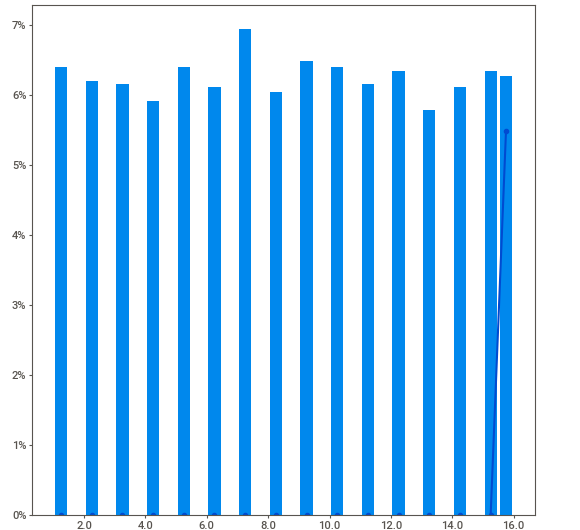
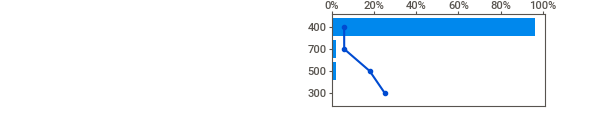
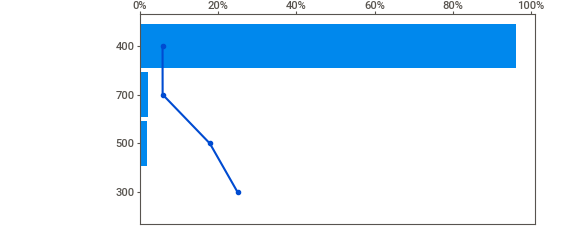
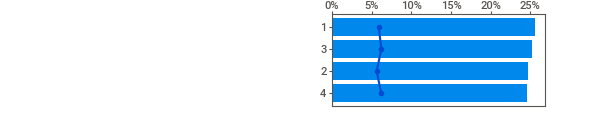
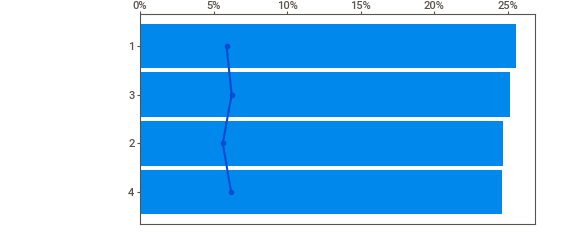
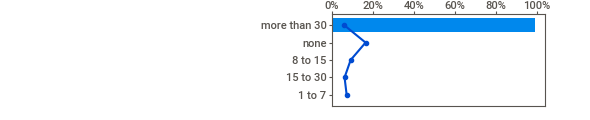
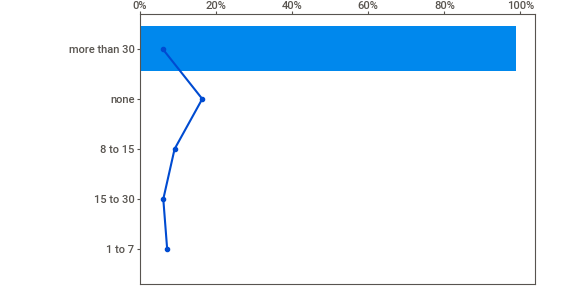
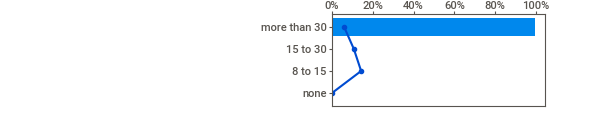
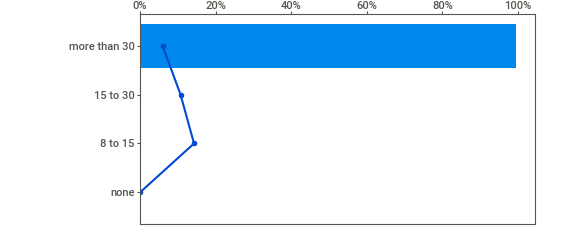
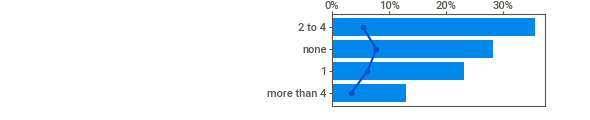
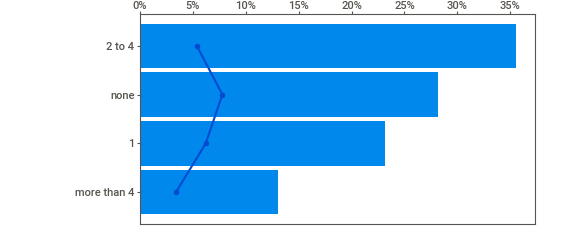
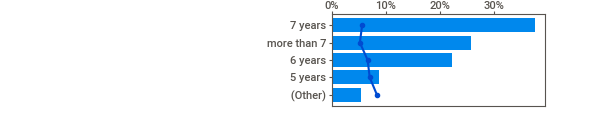
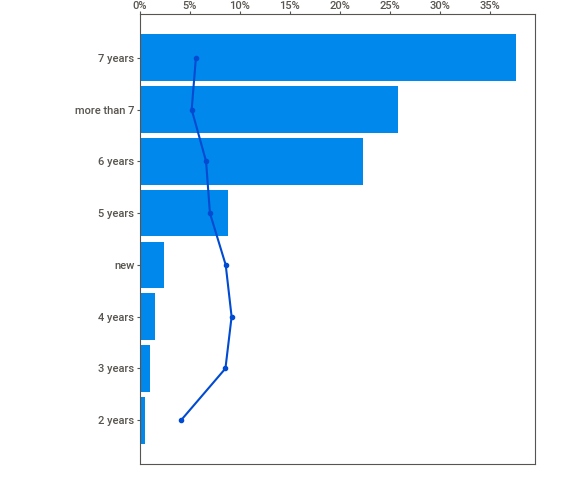
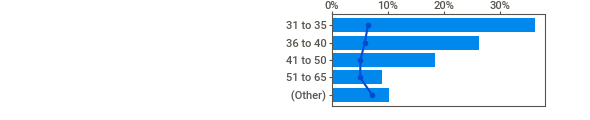
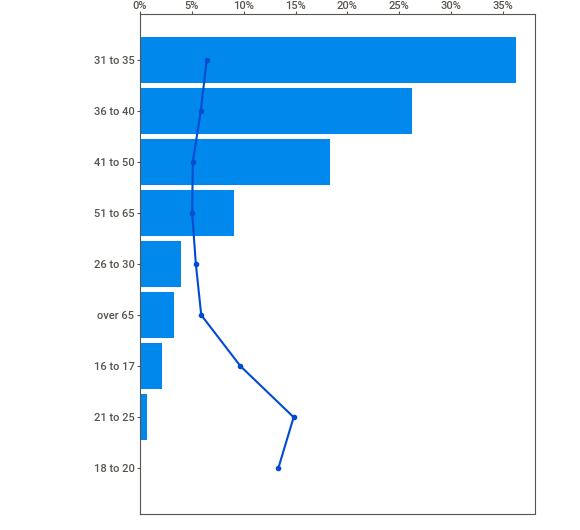
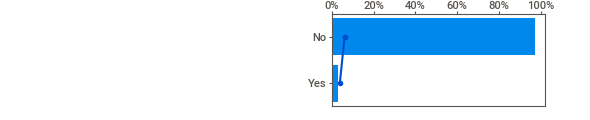
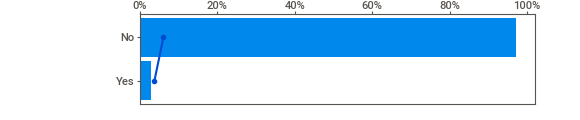
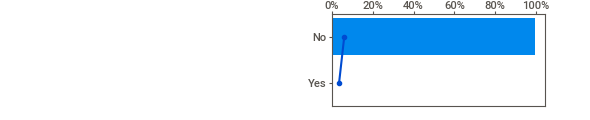
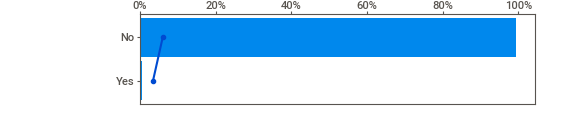
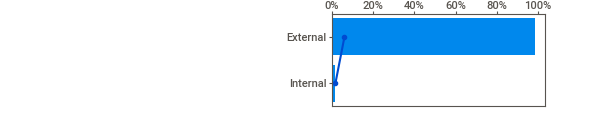
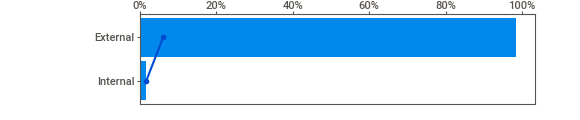
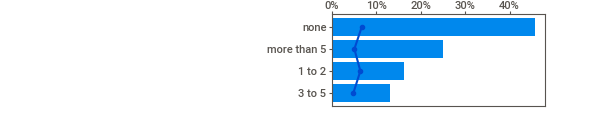
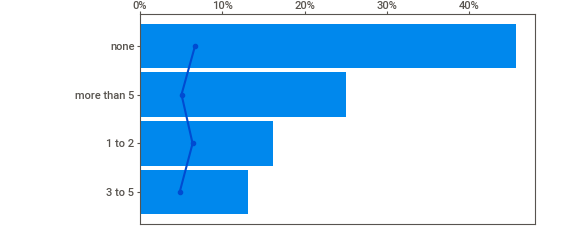
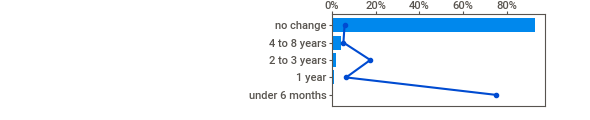
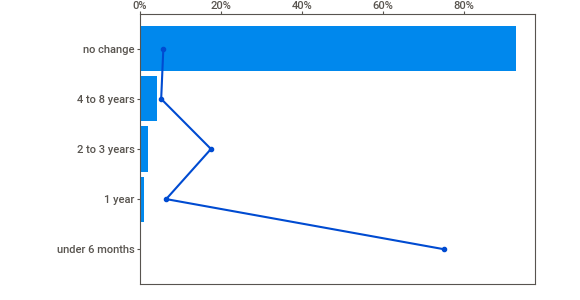
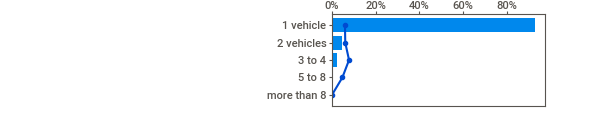
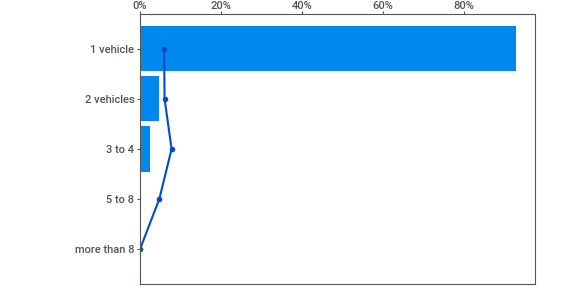
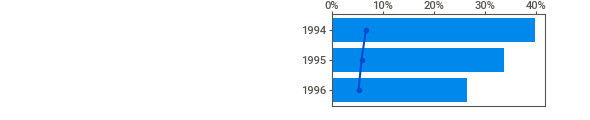
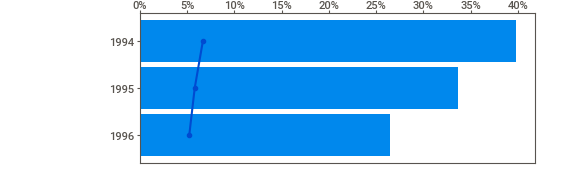
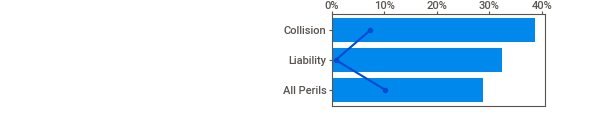
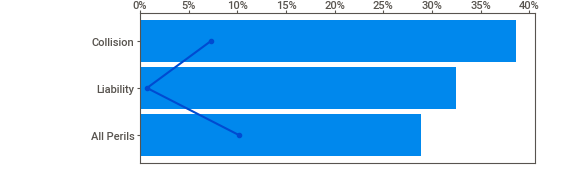
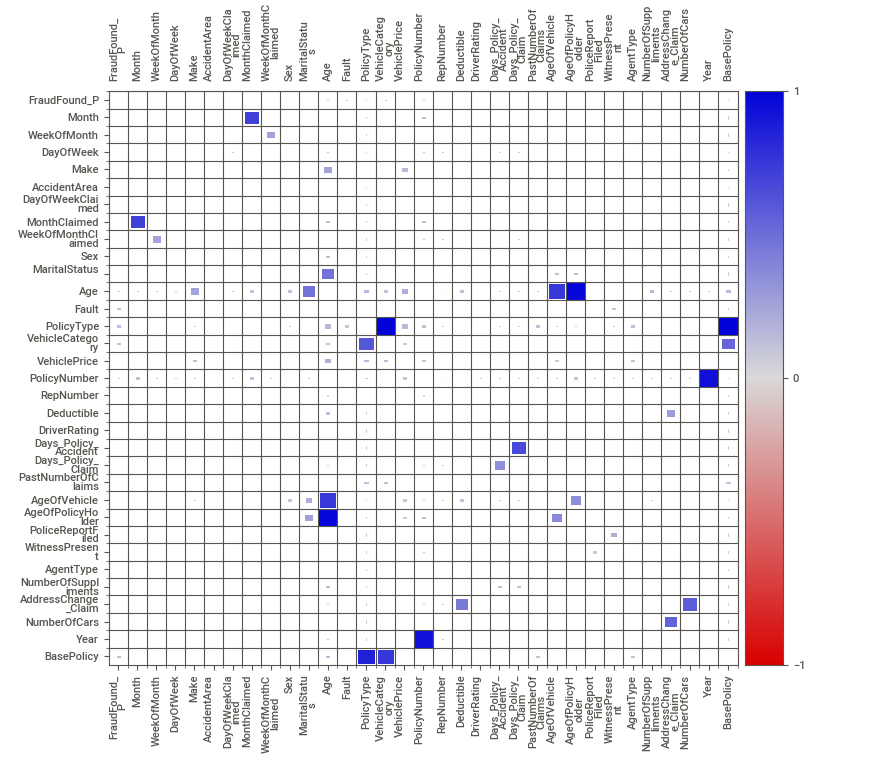
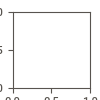

In [8]:
analyze_report = sv.analyze([df,'Train'], 'FraudFound_P')
analyze_report.show_notebook(w=900, h=750, scale=0.9)

## 3. data cleaning

### 3.1 check data types consistency

In [9]:
df.dtypes.value_counts()

object    24
int64      9
dtype: int64

In [10]:
df.select_dtypes(['object']).columns.tolist()

['Month',
 'DayOfWeek',
 'Make',
 'AccidentArea',
 'DayOfWeekClaimed',
 'MonthClaimed',
 'Sex',
 'MaritalStatus',
 'Fault',
 'PolicyType',
 'VehicleCategory',
 'VehiclePrice',
 'Days_Policy_Accident',
 'Days_Policy_Claim',
 'PastNumberOfClaims',
 'AgeOfVehicle',
 'AgeOfPolicyHolder',
 'PoliceReportFiled',
 'WitnessPresent',
 'AgentType',
 'NumberOfSuppliments',
 'AddressChange_Claim',
 'NumberOfCars',
 'BasePolicy']

In [11]:
len(df.select_dtypes(['object']).applymap(type).value_counts())

1

### 3.2 check null values and column types¶ 

In [12]:
df.info(show_counts=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

#### 3.2.1 confirm that there are no null values

In [13]:
df.isnull().any(axis=0).any()

False

### 3.3 check for duplicates

In [14]:
print(f"{len(df[df.duplicated()])} entries are duplicates")

0 entries are duplicates


## 4. data analysis and feature extraction

### 4.1 univariate and bivariate analysis of original data

#### 4.1.1 univariate analysis

In [15]:
df.FraudFound_P.value_counts()

0    14497
1      923
Name: FraudFound_P, dtype: int64

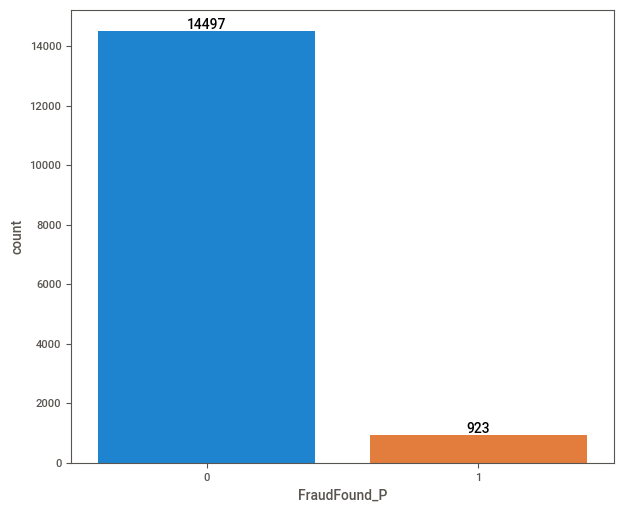

In [16]:
plt.figure(figsize=(7,6))
ax=sns.countplot(data=df, x='FraudFound_P');
ax.bar_label(ax.containers[0]);

In [17]:
df.FraudFound_P.value_counts(normalize=1) * 100.

0    94.014267
1     5.985733
Name: FraudFound_P, dtype: float64

#### 4.1.2 bivariate analysis

In [18]:
df.select_dtypes(["int", "float"])

,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Year
0,5,1,21,0,1,12,300,1,1994
1,3,4,34,0,2,15,400,4,1994
2,5,2,47,0,3,7,400,3,1994
3,2,1,65,0,4,4,400,2,1994
4,5,2,27,0,5,3,400,1,1994
...,...,...,...,...,...,...,...,...,...
15415,4,5,35,1,15416,5,400,4,1996
15416,5,1,30,0,15417,11,400,3,1996
15417,5,1,24,1,15418,4,400,4,1996
15418,1,2,34,0,15419,6,400,4,1996


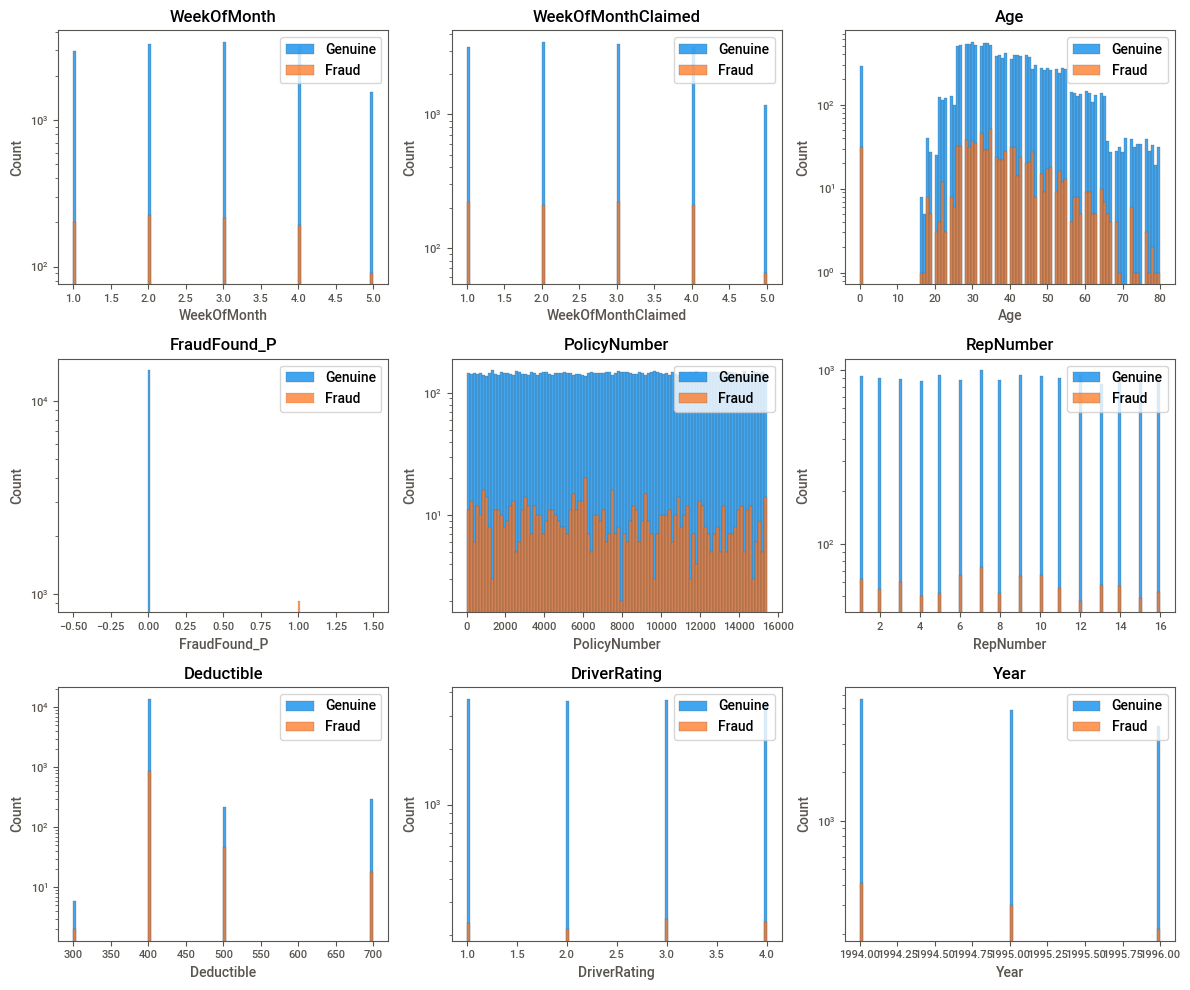

In [19]:
def plot_numerical_features(features):    
    fig, ax = plt.subplots(3, len(features)//3, figsize=(12, 10))
    i = 0
    for feature in features:
        i += 1
        plt.subplot(3, len(features)//3, i)
        sns.histplot(df[df['FraudFound_P']==0][feature], bins=100, label="Genuine")
        sns.histplot(df[df['FraudFound_P']==1][feature], bins=100, label="Fraud")
        plt.title(feature)
        plt.yscale('log')
        plt.legend()
    fig.tight_layout() 
    plt.show()

plot_numerical_features(df.select_dtypes(["int", "float"]).columns)

In [20]:
df.select_dtypes(["object"]).columns

Index(['Month', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed',
       'MonthClaimed', 'Sex', 'MaritalStatus', 'Fault', 'PolicyType',
       'VehicleCategory', 'VehiclePrice', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars',
       'BasePolicy'],
      dtype='object')

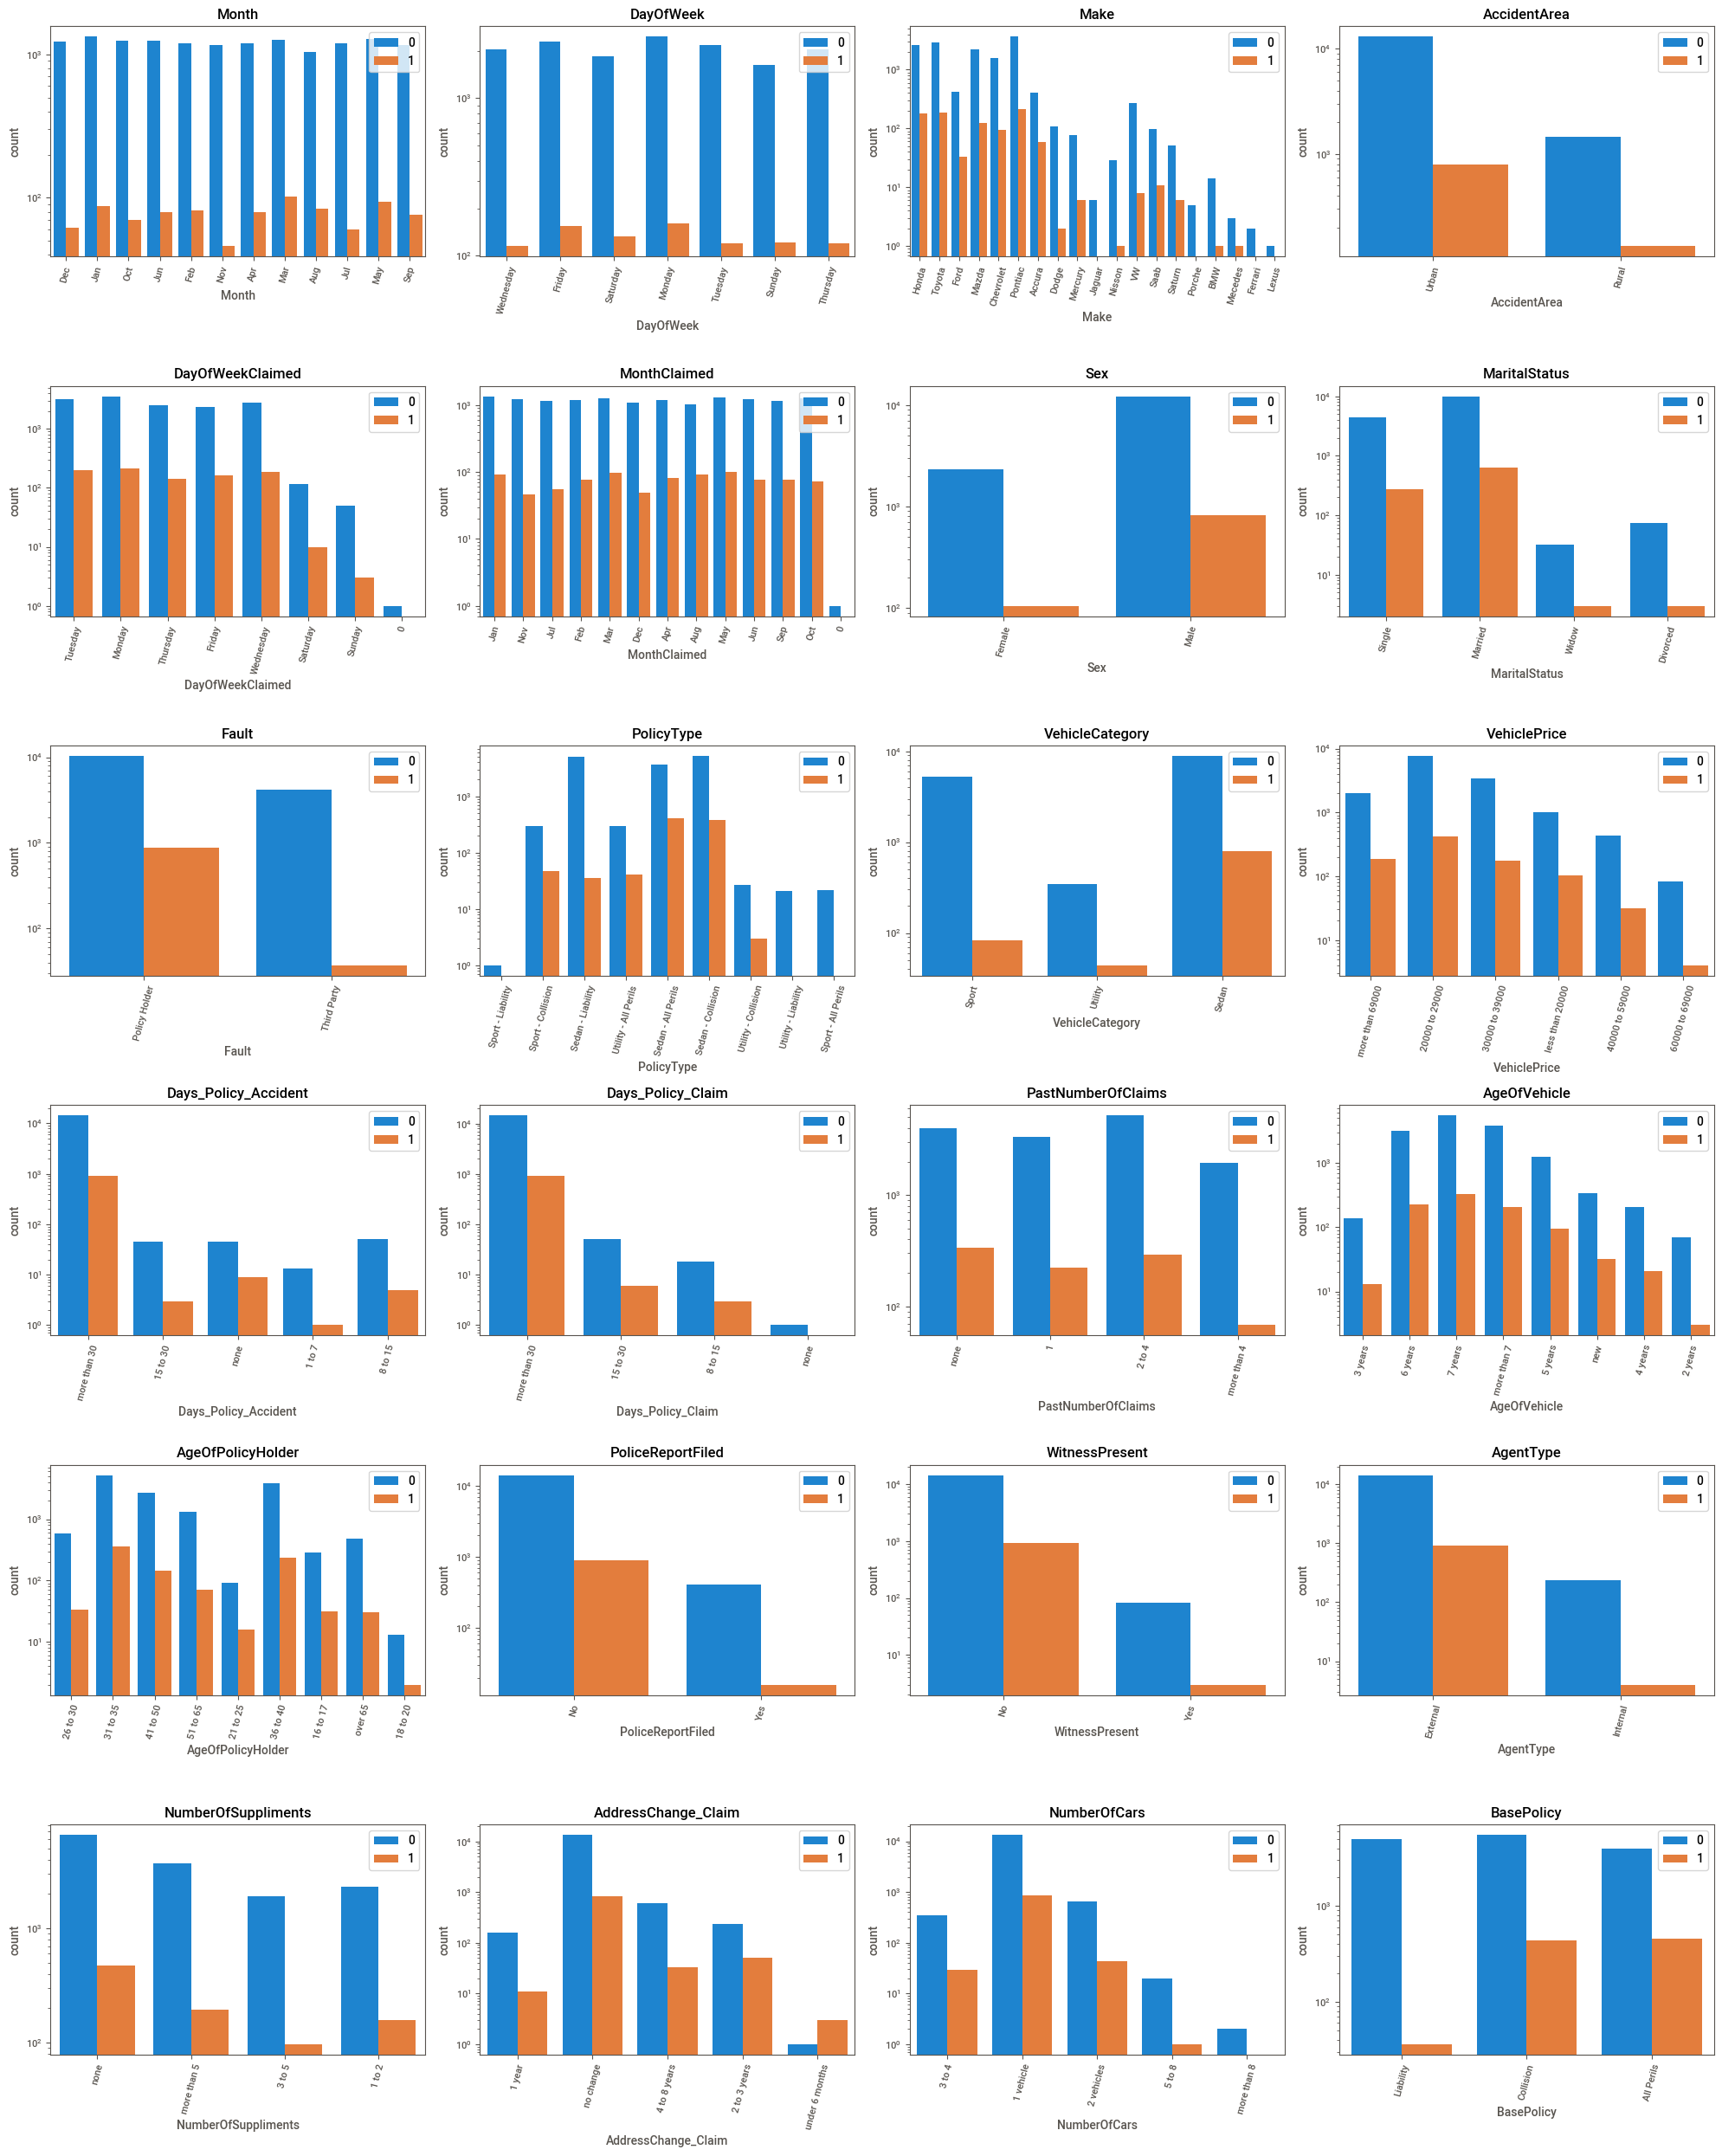

In [21]:
def bivariate_countplot(features):    
    fig, ax = plt.subplots(6, len(features)//5, figsize=(20, 25))
    i = 0
    for feature in features:
        i += 1
        plt.subplot(6, len(features)//5, i)
        ax=sns.countplot(data=df, x=feature, hue='FraudFound_P')
        ax.tick_params(axis='x', labelrotation = 75)
        plt.title(feature)
        plt.yscale('log')
        plt.legend()
    fig.tight_layout() 
    plt.show()

bivariate_countplot(df.select_dtypes(["object"]).columns)

In [22]:
df_one_hot = pd.concat([df.select_dtypes(["int", "float"]), pd.get_dummies(df.select_dtypes(["object"])).astype(int)], axis=1)

In [23]:
df_one_hot.shape

(15420, 149)

In [24]:
df_one_hot.T

,0,1,2,3,4,5,6,7,8,9,...,15410,15411,15412,15413,15414,15415,15416,15417,15418,15419
WeekOfMonth,5,3,5,2,5,4,1,1,4,3,...,3,4,4,4,4,4,5,5,1,2
WeekOfMonthClaimed,1,4,2,1,2,1,3,4,5,3,...,4,5,4,4,4,5,1,1,2,3
Age,21,34,47,65,27,20,36,0,30,42,...,31,42,28,40,58,35,30,24,34,21
FraudFound_P,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,1
PolicyNumber,1,2,3,4,5,6,7,8,9,10,...,15411,15412,15413,15414,15415,15416,15417,15418,15419,15420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NumberOfCars_5 to 8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NumberOfCars_more than 8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BasePolicy_All Perils,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
BasePolicy_Collision,0,1,1,0,1,1,1,1,1,0,...,1,0,0,0,1,1,0,1,0,1


## 5. model training and evaluation

In [25]:
random_seed=55

In [26]:
X, y = df_one_hot[[c for c in df_one_hot.columns if c not in ["FraudFound_P", "Year", "PolicyNumber"]]], df_one_hot['FraudFound_P']  

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_seed)

In [64]:
y_train.mean(), y_test.mean()

(0.05987894509295288, 0.05966277561608301)

In [28]:
def train_model(model, *args, **kwargs):
    start = time.time()

    param_dist = {'max_depth': randint(5, 20),
              'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5],
              'n_estimators': randint(10, 500),
             }
    
    # Define the stratified cross-validation strategy 
    skcv = StratifiedKFold(n_splits=3) 

    # Run randomized search
    rand_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=3, cv=skcv, random_state=random_seed, scoring="average_precision")

    # Fit the randomized search to the training data
    rand_search.fit(X_train, y_train, **kwargs)

    # Print the best hyperparameters
    print('Best hyperparameters:', rand_search.best_params_)

    # return the trained model
    model = rand_search.best_estimator_

    print(time.time()-start)
    
    return model

#### 5.2.1 sklearn gbt

In [29]:
# Create a GradientBoostingClassifier model
gb = GradientBoostingClassifier(random_state=random_seed)

# Return the trained model
model_sklearn = train_model(gb)

Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 184}
138.24901485443115


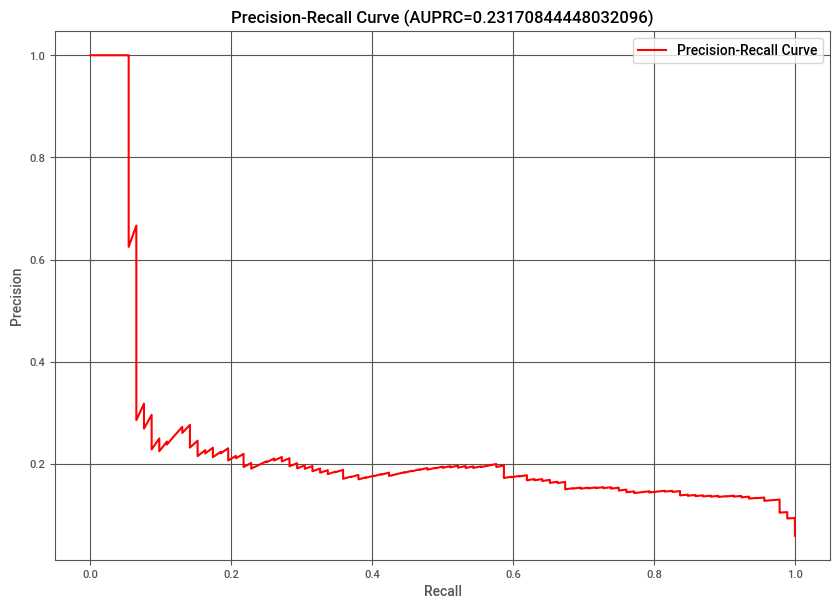

In [30]:
def evaluate(model):
    plt.figure(figsize=(10,7))
    y_pred_prob = model.predict_proba(X_test)
    # Compute precision and recall
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob[:,1])
    auprc = average_precision_score(y_test, y_pred_prob[:,1])
    # Plot precision-recall curve
    plt.plot(recall, precision, label='Precision-Recall Curve', color='r')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (AUPRC={auprc})')
    plt.legend()
    plt.grid(True)
evaluate(model_sklearn)

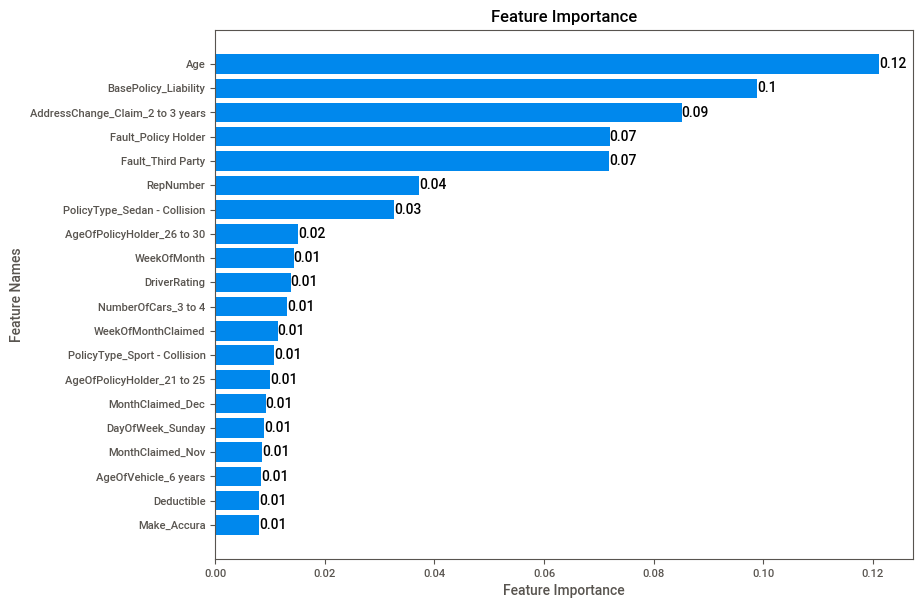

In [31]:
def plot_feature_importances(model):
    plt.figure(figsize=(9, 7))
    if model.__class__.__module__ == "lightgbm.sklearn":
        feature_names = model.feature_name_
    elif model.__class__.__module__ == "catboost.core":
        feature_names = model.feature_names_
    else:
        feature_names= model.feature_names_in_
    sorted_features = sorted(zip(feature_names, model.feature_importances_), key=lambda c: abs(c[1]))
    sorted_names, sorted_imp = zip(*sorted_features[-20:])
    plt.barh(range(len(sorted_imp)), sorted_imp, align='center')
    for i, v in enumerate(sorted_imp):
        plt.text(v, i, str(round(v, 2)), va='center')
    plt.yticks(range(len(sorted_imp)), sorted_names)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.title('Feature Importance')
    plt.show()
plot_feature_importances(model_sklearn)

#### 5.2.2 xgboost gbt

In [32]:
# Create an XGBoost model
xgb = XGBClassifier(random_state=random_seed)

# return the trained model
model_xgb = train_model(xgb)

Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 184}
38.55962610244751


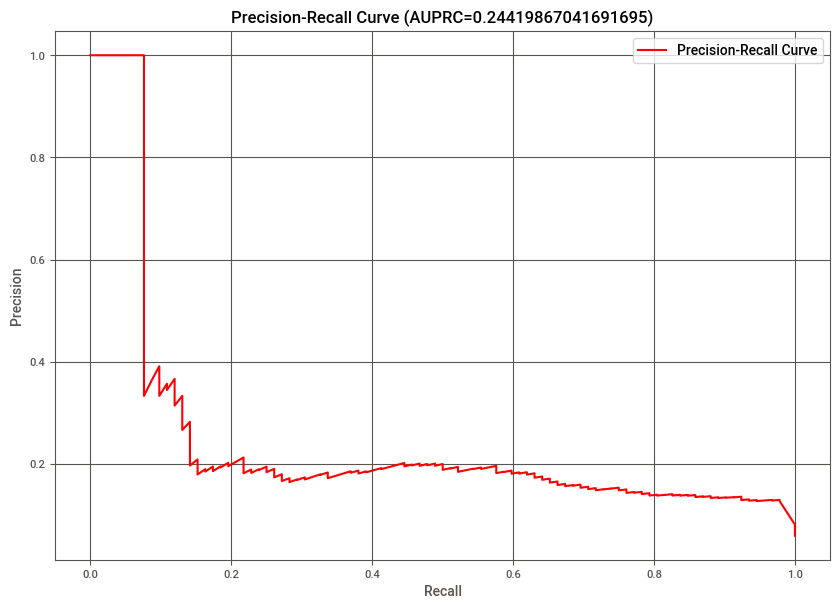

In [33]:
evaluate(model_xgb)

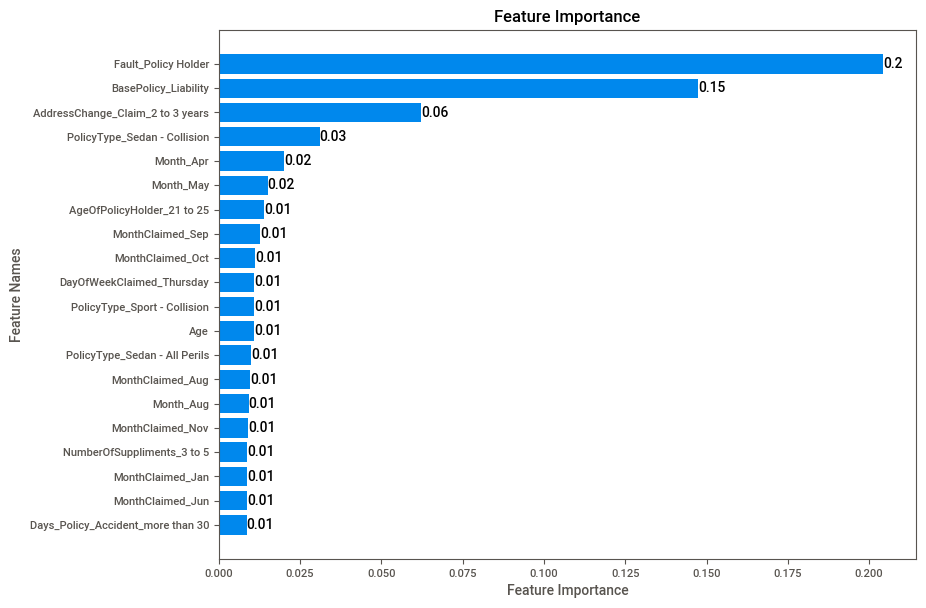

In [34]:
plot_feature_importances(model_xgb)

#### 5.2.3 lightgbm gbt

In [35]:
# Create a LightGBM model
lgbm = LGBMClassifier(random_state=random_seed)

# return the trained model
model_lgbm = train_model(lgbm)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

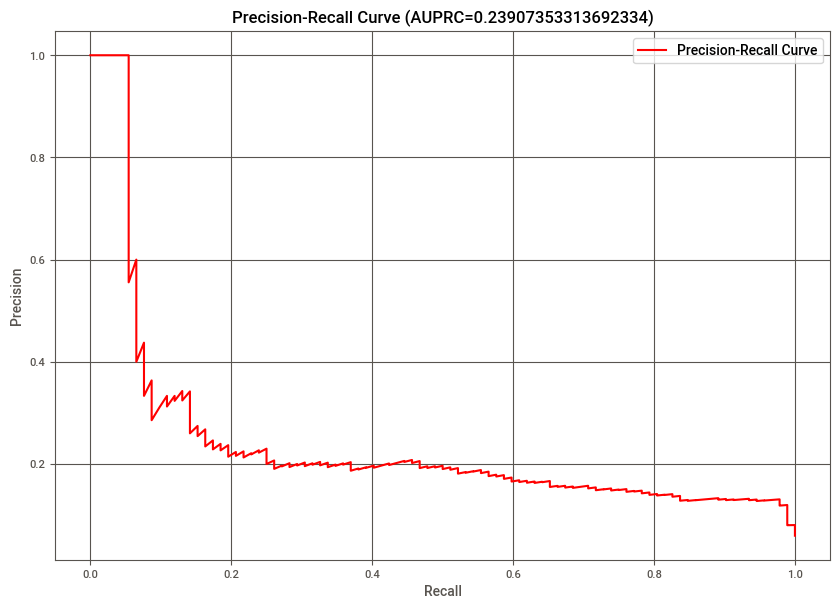

In [36]:
evaluate(model_lgbm)

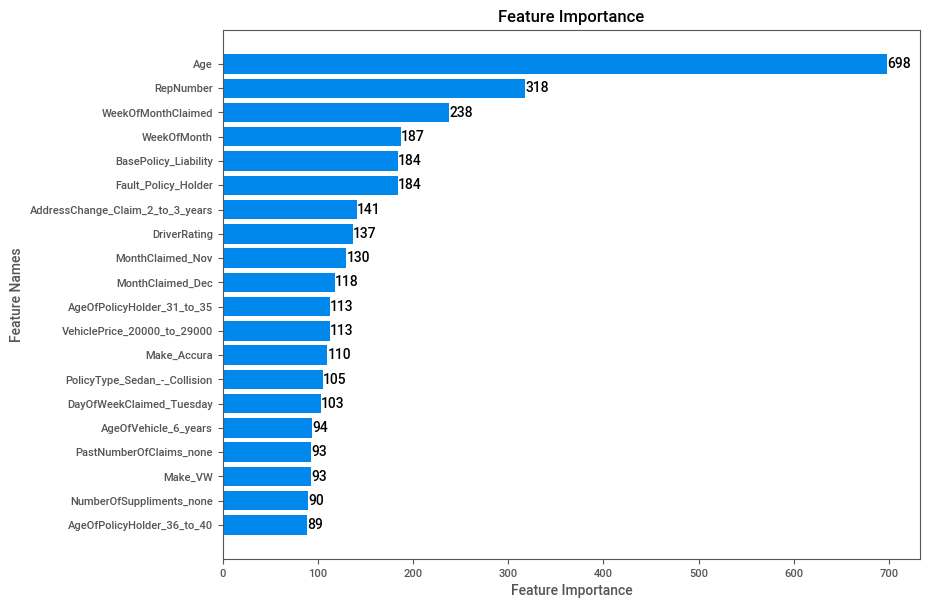

In [37]:
plot_feature_importances(model_lgbm)

#### 5.2.4 catboost

In [40]:
# Create a CatBoost model
catboost = CatBoostClassifier(random_state=random_seed)

# Return the trained model
model_cat = train_model(catboost, verbose=0)

Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 184}
54.275949001312256


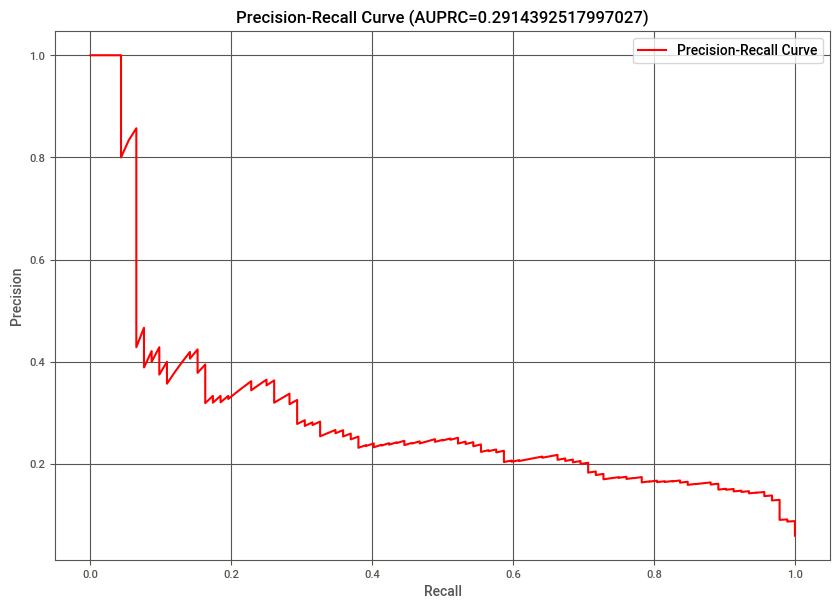

In [41]:
evaluate(model_cat)

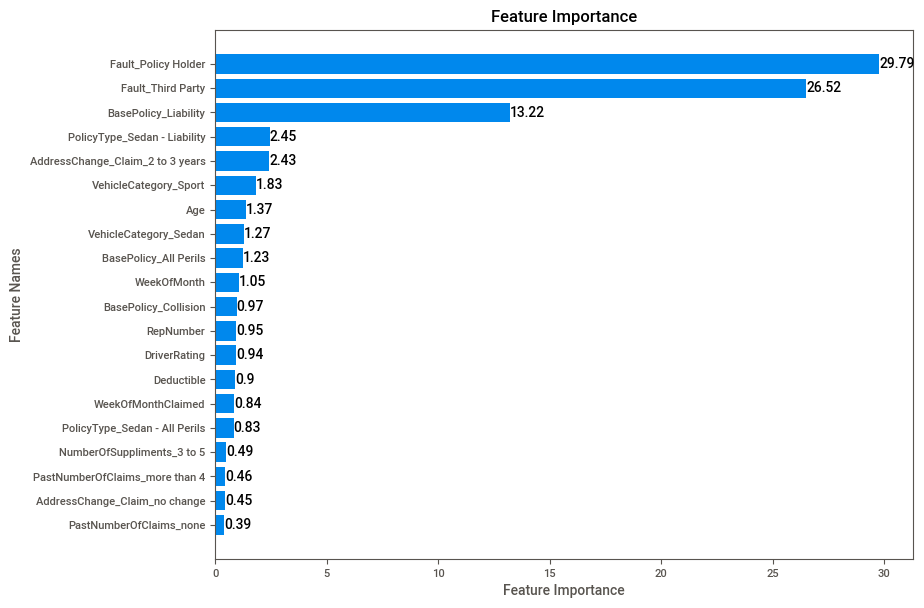

In [42]:
plot_feature_importances(model_cat)

In [43]:
X = df[[c for c in df.columns if c not in ["FraudFound_P", "Year", "PolicyNumber"]]]
y = df["FraudFound_P"]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_seed)

In [46]:
# Create a CatBoost model
catboost = CatBoostClassifier(random_state=random_seed)

# Return the trained model
model_cat2 = train_model(catboost, verbose=0, cat_features=X_train.select_dtypes("object").columns.tolist())

Best hyperparameters: {'learning_rate': 0.25, 'max_depth': 6, 'n_estimators': 64}
66.47319388389587


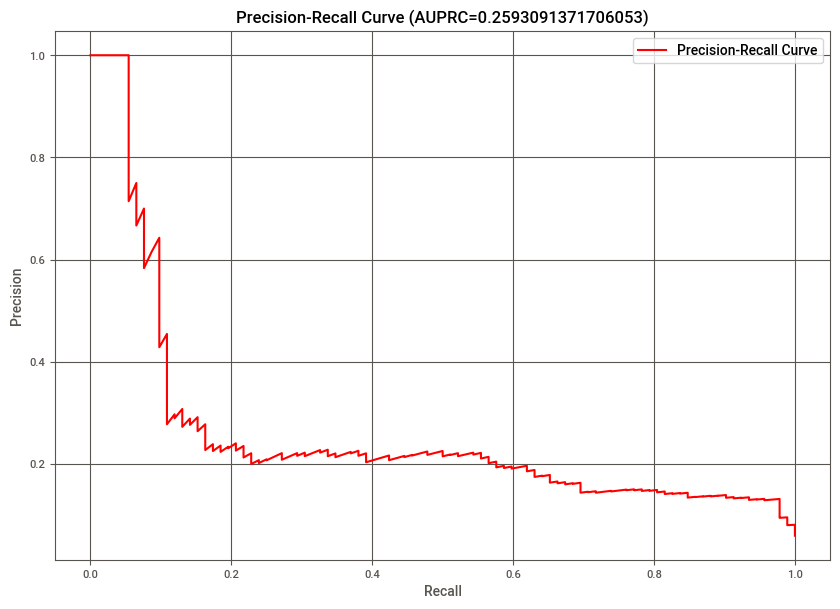

In [47]:
evaluate(model_cat2)

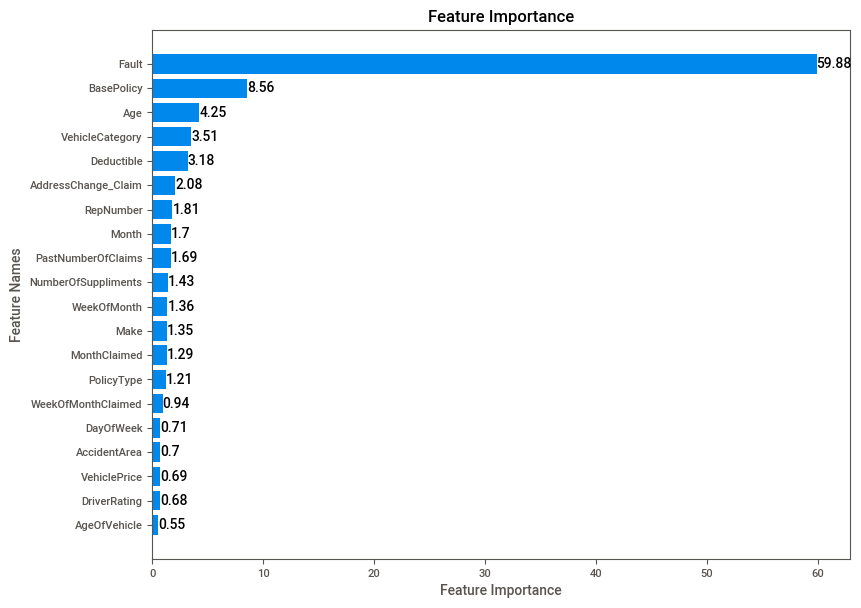

In [48]:
plot_feature_importances(model_cat2)